### Generate Predictions using Trained Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join('diffusionsim')))
import dask
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs
import json
#fs = gcsfs.GCSFileSystem()

In [2]:
import diffusers
import diffusionsim as diff
import diffusionsim.training_utils as tru
from diffusionsim import mydatasets as data

ModuleNotFoundError: No module named 'diffusers'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
exp_id = "full_dataset_testrun"
base_dir = os.path.join("experiments", exp_id)
run_id = "trial_1b"
tconfig, mconfig, dconfig = tru.load_config(run_id, exp_id)
with open(os.path.join(base_dir, "trial_1b.json"), 'r') as file:
    log = json.load(file)

In [5]:
dconfig.train_test_split = [0.1, 0.1]

In [6]:
dconfig.dataloader_params.batch_size = 32
train_ds, test_ds = data.load_dataset(dconfig)

In [ ]:
def plot_loss(log):
    len(log['train_loss'])
    plt.plot(log['train_loss'])
    batches_per_epoch = np.ceil(dataset.data.time.shape[0]  / 128 / 25)
    num_batches, num_epochs = len(log['train_loss']), tconfig.num_epochs + 1
    plt.xticks(np.arange(0, num_batches, batches_per_epoch), labels=np.arange(1, num_epochs))
    plt.title("Training Loss over time")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [16]:
#trainer = tru.setup_trainer(exp_id, run_id, tconfig, mconfig, dconfig)
#trainer.dataloaders['train'].dataset.log = False

In [7]:
ddpm = tru.load_model_from_ckpt(f"{run_id}-ckpt.pt", mconfig, exp_id).to(device)
mconfig.scheduler_type = "ddim"
scheduler = data.load_scheduler(mconfig)
ddpm.device

device(type='cuda', index=0)

In [8]:
scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.30.3",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": false,
  "clip_sample_range": 4.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 100,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [9]:
def recreate_sample(sample, dataset=train_ds):
    arr = sample.numpy().reshape(-1, 128, 384)
    xarr = xr.DataArray(arr, dims="time mlo ncol".split(), coords=dict(
        time = np.arange(arr.shape[0]),
        mlo = dataset.mlo, 
        ncol = dataset.permute_indices
    )).isel(ncol=np.argsort(dataset.permute_indices))
    mu_stack = dataset.Ymean.to_stacked_array(new_dim="mlo", sample_dims=('ncol',))
    sig_stack = dataset.Ystd.to_stacked_array(new_dim="mlo", sample_dims=('ncol',))
    xrec = (xarr * sig_stack.mean(dim='ncol')) + mu_stack.mean(dim='ncol')
    return(xrec.transpose("time", "ncol", "mlo"))

#### Testing Sample Recreation

In [19]:
sample = recreate_sample(dataset[0])

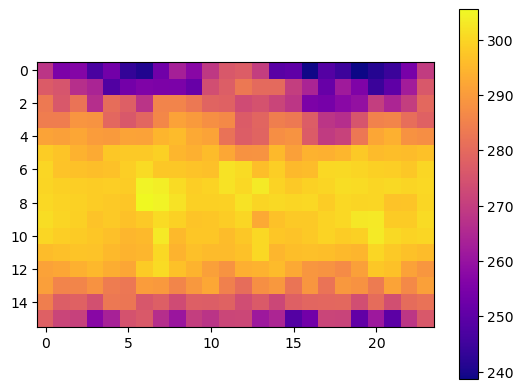

In [20]:
tmap = sample.isel(time=0, mlo=59, ncol=dataset.permute_indices).data
plt.imshow(tmap.reshape(16, 24), cmap='plasma')
plt.colorbar()
plt.show()

In [60]:
og = dataset.data.state_t.sel(time=0, lev=59, ncol=dataset.permute_indices).load().data

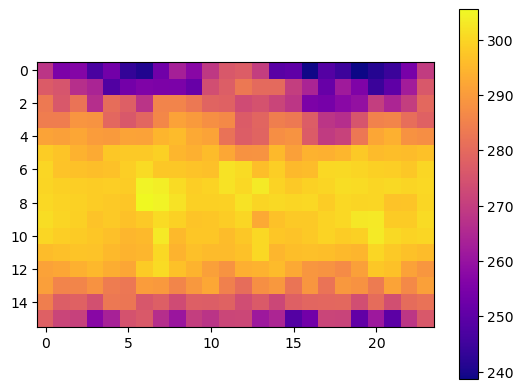

In [67]:
plt.imshow(og.reshape(16, 24), cmap='plasma')
plt.colorbar()
plt.show()

In [70]:
ds0 = dataset.bgen[0].load()
ds0 = ds0.to_stacked_array(new_dim='mlo', sample_dims=("time", "ncol"))

In [71]:
np.isclose(sample, ds0, atol=5e-5).all()

True

In [21]:
original_stderr_write = sys.stderr.write
# Define a custom stderr.write that filters out the OpenBLAS warning
def suppressed_stderr_write(message, omit='OpenBlas'):
    original_stderr_write = sys.stderr.write    
    if omit not in message:
        original_stderr_write(message)

sys.stderr.write = suppressed_stderr_write

#### testing pipeline speed

In [89]:
gen = torch.Generator()
gen

In [90]:
#os.environ['OPENBLAS_VERBOSE'] = '0'
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)

In [91]:
import time
pipeline_test = dict(sizes=[1, 2, 4, 8, 16, 32, 64, 128, 256], times=[], batches=[], device=device)

for sz in pipeline_test['sizes']:
    print(f"generating {sz} images from pipeline")
    now = time.time()
    images = pipeline(eta=0, batch_size=sz, generator=gen, num_inference_steps=50, output_type='numpy').images
    pipeline_test['times'].append(time.time() - now)
    pipeline_test['batches'].append(images)

generating 1 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 2 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 4 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 8 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 16 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 32 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 64 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 128 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

generating 256 images from pipeline


  0%|          | 0/50 [00:00<?, ?it/s]

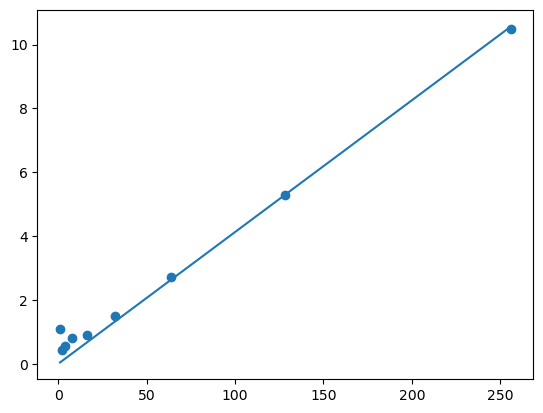

In [92]:
m, b = np.polyfit(pipeline_test['sizes'][:len(pipeline_test['times'])], pipeline_test['times'], 1)
slope = np.dot(pipeline_test['sizes'][:len(pipeline_test['times'])], pipeline_test['times']) / np.dot(pipeline_test['sizes'], pipeline_test['sizes'])

plt.scatter(pipeline_test['sizes'][:len(pipeline_test['times'])], pipeline_test['times'])
plt.plot(pipeline_test['sizes'][:len(pipeline_test['times'])], np.array(pipeline_test['sizes'][:len(pipeline_test['times'])]) * slope)


seems like batch size does not really matter for generation speed- seconds/sample stays the same. 

(array([1232349.,  745020., 1084634., 1470926., 1759822., 1759558.,
        1474366., 1084381.,  743111., 1228745.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

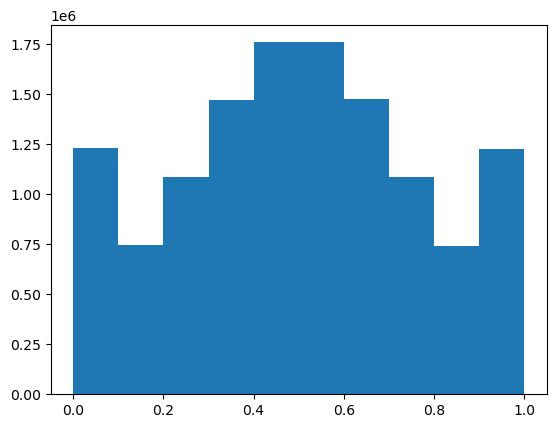

In [93]:
plt.hist(np.array(pipeline_test['batches'][-1]).flatten())

In [94]:
images = np.transpose(images, (0, 3, 1, 2))
images.shape

(256, 128, 16, 24)

In [ ]:
plt.imshow(images[0, 59])

### Comparing empirical dataset norms to saved

In [ ]:
from climsim_data_utils import data_utils, load_vars

In [ ]:
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
grid_info = xr.open_dataset(mapper, engine='zarr')

dutils = data_utils(grid_info=grid_info)

In [ ]:
def reconstruct_np(X_norm, Y_norm, data_vars='v1'):
    inputs, outputs = load_vars(data_vars)
    input_mean = xr.open_dataset('Climsim_info/input_mean.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values
    input_max = xr.open_dataset('Climsim_info/input_max.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values
    input_min = xr.open_dataset('Climsim_info/input_min.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values
    output_scale = xr.open_dataset('Climsim_info/output_scale.nc')[inputs].to_stacked_array('mlvar', sample_dims='').values

    X = X_norm*(input_max - input_min) + input_mean
    Y = Y_norm / output_scale
    return(X,Y)

In [ ]:
x_avg = x_npy.mean(axis=0)
x_avg.shape

In [ ]:
x_norm = xr.open_dataset("Climsim_info/input_mean.nc")

In [64]:
x_norm_v1 = x_norm[dutils.v1_inputs].to_stacked_array('mlvar', sample_dims='').values

In [75]:
(x_avg -x_norm_v1)

array([-2.56817731e-02,  4.18193672e-02,  9.98839433e-03,  6.54797630e-05,
        2.16402490e-03, -2.84236218e-03, -7.80040626e-03, -7.79458220e-04,
        6.23871345e-03,  5.40563035e-03,  2.17198329e-03,  3.37880128e-04,
       -5.97191006e-04, -9.69804839e-04,  5.85265309e-04,  1.21450536e-03,
       -3.11999986e-03, -3.44376894e-03,  5.46327227e-03,  7.97039341e-03,
        6.71671362e-03,  5.06742930e-03,  2.17408058e-03, -1.35648329e-03,
       -4.15770949e-03, -6.98711656e-03, -9.16070289e-03, -1.06326176e-02,
       -1.12655234e-02, -1.12312231e-02, -1.09699861e-02, -1.07240824e-02,
       -1.05749213e-02, -1.01690826e-02, -9.24284257e-03, -7.57338261e-03,
       -5.09230842e-03, -2.87782532e-03, -1.14609395e-03,  4.11092162e-04,
        1.60435950e-03,  2.65040335e-03,  3.15641661e-03,  3.28444663e-03,
        3.01585356e-03,  2.99826758e-03,  4.39359316e-03,  7.46977212e-03,
        1.22814718e-02,  1.88928090e-02,  2.60559371e-02,  3.35944514e-02,
        4.12411248e-02,  

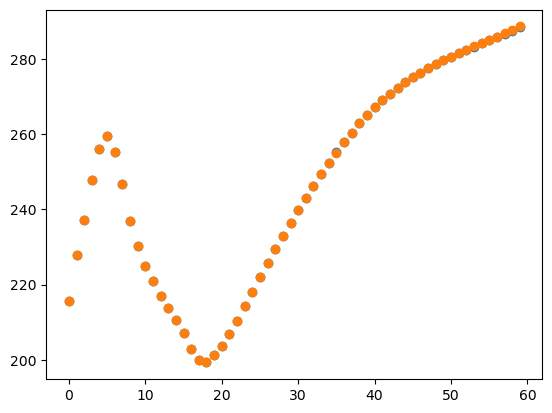

In [69]:
plt.scatter(np.arange(60), x_norm_v1[:60])
plt.scatter(np.arange(60), x_avg[:60])

In [45]:
output_scaling = xr.open_dataset("Climsim_info/output_scale.nc")

oscaling  = output_scaling[dutils.v1_outputs].to_stacked_array('mlvar', sample_dims='').values

In [52]:
y_avg = y_npy.mean(axis=0)
y_scale_test = 1./ y_avg

/tmp/ipykernel_626/3185387537.py:2: RuntimeWarning: divide by zero encountered in divide
  y_scale_test = 1./ y_avg


In [54]:
y_avg

array([ 1.19014050e-05, -1.13608688e-05, -5.22001272e-06, -1.83795208e-06,
       -1.83506310e-06,  7.04202705e-07,  1.36045056e-06,  8.66873477e-07,
        1.65614915e-08, -9.96006355e-08,  3.42032446e-07,  5.19593379e-07,
        6.27532105e-07,  6.53872793e-07,  7.57789509e-07,  1.05315910e-06,
        1.64673863e-06,  1.35920795e-06,  6.38992441e-07, -5.41416933e-07,
       -6.43335666e-09, -2.26299367e-06, -3.69347862e-06, -5.13319715e-06,
       -6.32380659e-06, -6.27994870e-06, -5.32568580e-06, -4.25518677e-06,
       -3.33941632e-06, -2.52159343e-06, -1.73624515e-06, -1.34164169e-06,
       -6.12715034e-07,  1.00480138e-07,  6.40130091e-07,  8.57316853e-07,
        1.44235977e-06,  1.70224506e-06,  1.48805081e-06,  1.39098697e-06,
        1.65367745e-06,  2.02146425e-06,  1.71443179e-06,  1.11403501e-06,
        1.36902466e-06,  1.54391288e-06,  2.10816170e-06,  3.53536307e-06,
        4.23332185e-06,  5.19102267e-06,  4.95795627e-06,  6.65066905e-06,
        7.07406187e-06,  

In [53]:
y_scale_test

array([ 8.40236928e+04, -8.80214374e+04, -1.91570414e+05, -5.44083826e+05,
       -5.44940390e+05,  1.42004567e+06,  7.35050598e+05,  1.15357088e+06,
        6.03810352e+07, -1.00400966e+07,  2.92369923e+06,  1.92458187e+06,
        1.59354397e+06,  1.52934945e+06,  1.31962767e+06,  9.49524147e+05,
        6.07260911e+05,  7.35722592e+05,  1.56496374e+06, -1.84700540e+06,
       -1.55439851e+08, -4.41892530e+05, -2.70747472e+05, -1.94810363e+05,
       -1.58132604e+05, -1.59236969e+05, -1.87769245e+05, -2.35007311e+05,
       -2.99453528e+05, -3.96574637e+05, -5.75955532e+05, -7.45355490e+05,
       -1.63208008e+06,  9.95221566e+06,  1.56218246e+06,  1.16642989e+06,
        6.93308299e+05,  5.87459482e+05,  6.72020063e+05,  7.18913996e+05,
        6.04712847e+05,  4.94690916e+05,  5.83283632e+05,  8.97637854e+05,
        7.30447030e+05,  6.47704940e+05,  4.74346915e+05,  2.82856380e+05,
        2.36221113e+05,  1.92640268e+05,  2.01696010e+05,  1.50360812e+05,
        1.41361500e+05,  

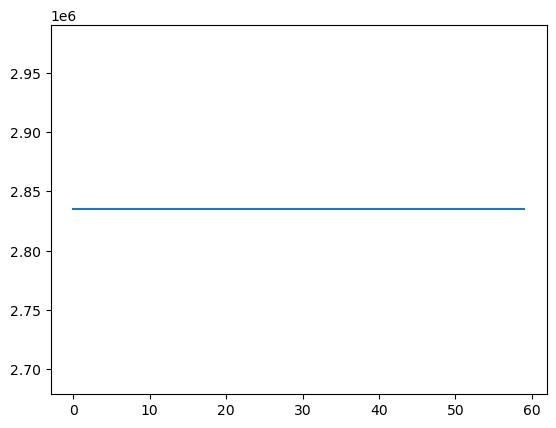

In [56]:
plt.plot(np.arange(60), oscaling[60:120])
#plt.plot(np.arange(60), y_scale_test[60:120])

In [33]:
oscaling.values()

ValuesView(<xarray.Dataset> Size: 1kB
Dimensions:         (lev: 60)
Dimensions without coordinates: lev
Data variables:
    ptend_t         (lev) float64 480B ...
    ptend_q0001     (lev) float64 480B ...
    cam_out_NETSW   float64 8B ...
    cam_out_FLWDS   float64 8B ...
    cam_out_PRECSC  float64 8B ...
    cam_out_PRECC   float64 8B ...
    cam_out_SOLS    float64 8B ...
    cam_out_SOLL    float64 8B ...
    cam_out_SOLSD   float64 8B ...
    cam_out_SOLLD   float64 8B ...)

# Evaluating

Ok so we have a diffusion model... is it any good?

In [10]:
pipeline = diffusers.DDIMPipeline(ddpm, scheduler)

[Check Pipeline Source Code](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddim/pipeline_ddim.py)

In [11]:
# generate images

class SampleImages(torch.utils.data.IterableDataset):
    def __init__(self, pipeline, steps, batch_size=1, eta=1.0):
        self.pipeline = pipeline.to(device)
        self.steps = steps
        self.batch_size = batch_size
        self.eta = 1.0
        self.image_shape = (batch_size, pipeline.unet.config.in_channels, *pipeline.unet.config.sample_size)
        
    def __iter__(self):
        # generate a batch of images
        scheduler = self.pipeline.scheduler
        while(True): # can generate infinite batches      
            image = torch.randn(self.image_shape).to(device)
            scheduler.set_timesteps(self.steps)
            for t in self.pipeline.progress_bar(scheduler.timesteps):
                model_output = self.pipeline.unet(image, t).sample
                image = scheduler.step(model_output, t, image, eta=self.eta).prev_sample
            yield(image)


In [12]:
model_loader = iter(SampleImages(pipeline, steps=50, batch_size=32, eta=0))

In [55]:
train_ds.log = False
train_ds[0].shape

torch.Size([32, 128, 16, 24])

In [13]:
images = next((model_loader))

  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [31]:
images.shape

torch.Size([32, 16, 24, 128])

In [35]:
images = images.cpu().detach().numpy()

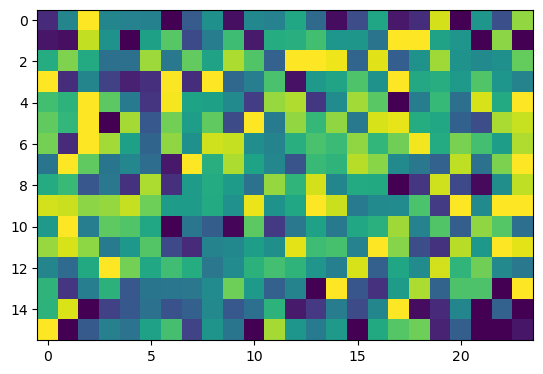

In [46]:
plt.imshow(images[0, :,:,59])

### Test One: Using DDPM as Encoder-Decoder
Let's imagine $x_{in} \in \mathbb{R}^{C \times H \times W}$ is the output of your ML emulator. I want to perturb $x$ to a noisy sample $z_t$; the larger the t, the further away I am taking from the image manifold before denoising back. 



Encoding: Noising a sample $$x_t(x_0, \epsilon) = \sqrt{\bar{\alpha_t}} \cdot x_0 + \sqrt{1-\bar{\alpha_t}} \cdot \epsilon$$

Decoding: De-Noising it and bring it closer to distribution
$$\epsilon_{\theta} = DDPM(z_t, t)$$
$$x_{t-1} \sim p_{\theta}(x_{t-1}|x_t) = \dfrac{1}{\sqrt{\alpha_t}}\left( x_t - \dfrac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_{\theta}\right) + \sigma_t z, z\sim \mathcal{N}(0, 1)$$


In [14]:
def encode(sample, t):
    if(isinstance(t,  int)):
        t = [t]
    eps = torch.randn(sample.shape, device=device) # BS x C x H x W
    xt = scheduler.add_noise(sample, eps, torch.LongTensor(t)) # noisy image
    return(xt, eps)

In [16]:
def decode(xt, T, unet=ddpm, scheduler=scheduler, track_history=True):
    if track_history:
        history = {T : xt}
    for t in range(T, 0, -1): # pipe.scheduler.timesteps[-T//stride-1:]
        with torch.no_grad():
            eps_theta = unet(xt, t).sample
        x_prev = scheduler.step(eps_theta, t, xt)
        xt = x_prev.prev_sample
        if track_history:
            history[t-1] = xt
            hist[t.item()] = image
    return(xt, history)

In [17]:
train_ds.log = False
item = train_ds[6]

{"event": "get-batch start", "time": 1728462082.4074104, "pid": 2671, "batch_idx": 6}
{"event": "get-batch end", "time": 1728462085.0249095, "pid": 2671, "batch_idx": 6, "duration": 2.617494821548462}


In [19]:
x25, eps = encode(item.to(device), 25)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

In [47]:
x0_hat, history25 = decode(x25, 25)

In [49]:
history.keys(), history25.keys()

(dict_keys([25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 'diffs']),
 dict_keys([25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]))

In [51]:
dist = torch.nn.MSELoss()
history25['diffs'] = []
for t in times:
    history25['diffs'].append(dist(item, history25[t]).item())

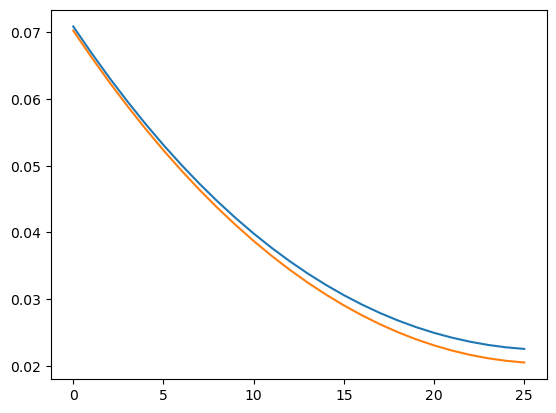

In [58]:
plt.plot(history['diffs'])
plt.plot(history25['diffs'])

In [ ]:
def denoising_assessment(dataset, indices, T):
    for i in indices:
        item = dataset[i]
        zT, eps = encode(item, T)
        x0_hat, history25 = decode(x25, 25)
        dist = torch.nn.MSELoss()
        history25['diffs'] = []
        for t in times:
            history25['diffs'].append(dist(item, history25[t]).item())

#### How it works

In [40]:
t = 25

In [41]:
zt, eps = encode(item, 25)

In [52]:
zt.shape

torch.Size([128, 128, 16, 24])

In [48]:
at = scheduler.alphas_cumprod[t]
zt_manual = torch.sqrt(at) * item + torch.sqrt(1-at)*eps

(zt_manual == zt).all().item()

True

In [55]:
with torch.no_grad():
    eps_theta = ddpm(zt.to(device), torch.tensor([25], device=device))

In [97]:
x24 = ddim_scheduler.step(eps_theta.sample, 25, zt.to(device)).prev_sample

In [98]:
x24.shape

torch.Size([128, 128, 16, 24])

In [86]:
a24 = ddim_scheduler.alphas_cumprod[24]
a25 = ddim_scheduler.alphas_cumprod[25]

DDIM Sampling:
$$x_{t-1} = \sqrt{\alpha_{t-1}}\left( \dfrac{x_t - \sqrt{1-\alpha_t} \epsilon_\theta}{\sqrt{\alpha_t}}\right) + \sqrt{1-\alpha_{t-1}} \cdot \epsilon_\theta$$

If taking larger strides, can replace $\alpha_{t-1}$ with $\alpha_{t-n}$

In [92]:
x24_manual = (zt.to(device) - torch.sqrt(1 - a25) * eps_theta.sample) / torch.sqrt(a25)
x24_manual = torch.sqrt(a24) * x24_manual + torch.sqrt(1 - a24) * eps_theta.sample

In [100]:
(x24 == x24_manual).all().item()

True

In [ ]:
scheduler.set_timesteps(50)
print(scheduler.timesteps) # x_t-1 becomes x80 | x90
print(scheduler.config.num_train_timesteps, scheduler.num_inference_steps)
scheduler.set_timesteps(100)

In [ ]:
T, stride = 20, 2
scheduler.set_timesteps(scheduler.config.num_train_timesteps // stride)
scheduler.timesteps[-T//stride-1:]

(array([ 9904.,  3771.,  3695.,  3560.,  3080.,  2686.,  2812.,  2961.,
         3787., 12896.]),
 array([-1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ]),
 <BarContainer object of 10 artists>)

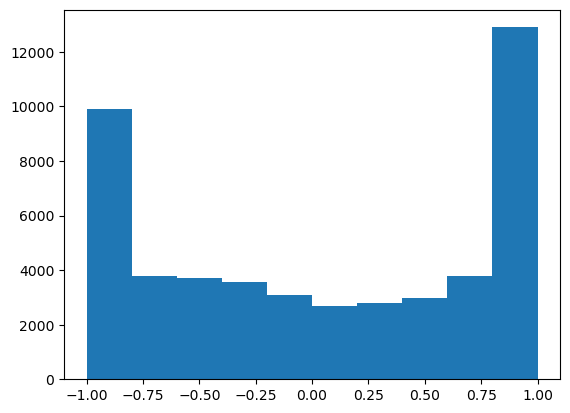

In [176]:
plt.hist(denoised_image.flatten()) # x0_reconstructed

(array([2.9500e+02, 3.8060e+03, 1.7294e+04, 2.0226e+04, 6.8030e+03,
        6.2800e+02, 8.1000e+01, 1.4000e+01, 3.0000e+00, 2.0000e+00]),
 array([-3.71876931, -2.53953576, -1.36030233, -0.18106887,  0.99816459,
         2.1773982 ,  3.35663152,  4.53586483,  5.71509838,  6.89433193,
         8.07356548]),
 <BarContainer object of 10 artists>)

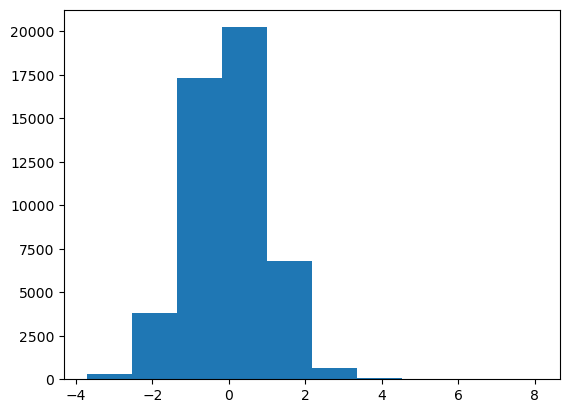

In [154]:
plt.hist(train_ds[0].flatten())

## Distribution Metrics

Series of evaluation metrics between two datasets $\mathcal S_r$ (training corpus) and $\mathcal S_f$ (generated images) respectively. Idea is to use N samples from each learned distribution and rate model on some kind of distribution distance metric. 

In [ ]:
vae_exp_id = "VAE_August05_08:23"
vae_log_pth = "trial_log.json"
with open(os.path.join("experiments", vae_exp_id, vae_log_pth), 'r') as file:
    vae_log = json.load(file)

vae_log.keys()
vae = tru.load_model_from_ckpt("best-ckpt.pt", vae_log['model_config'], vae_exp_id)

In [137]:
def compute_statistics(dataloader, num_samples, encoder):
    encoder.eval()
    features = []
    num_batches = num_samples // dataloader.batch_size + 1
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            print(f"batch {batch_idx}/{num_batches}")
            if batch_idx >= num_batches:
                break
            mu, sigma = encoder(batch)
            features.append(mu.view(mu.size(0), -1))  # Flatten each feature map
        all_features = torch.cat(features, dim=0)
        N, D = all_features.shape # combined into one huge num_samples x feature_size matrix
        assert N == num_batches*dataloader.batch_size, "Matrix dimensions do not match"
        mean = all_features.mean(dim=0)
        covariance = torch.mm((all_features - mean).T, (all_features - mean)) / (N-1) # feature_size by feature_size
    return mean, covariance, all_features

In [132]:
model_mean, model_covariance, all_features = compute_statistics(model_loader, 256, vae.encoder)

NameError: name 'vae' is not defined

In [164]:
model_covariance.shape

torch.Size([6144, 6144])

In [172]:
eps = 5
torch.cholesky(eps*torch.eye(6144, device=device), upper=False)

tensor([[2.2361, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.2361, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.2361,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 2.2361, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.2361, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.2361]],
       device='cuda:0')

In [150]:
meana = all_features.mean(dim=0)

In [152]:
(all_features - meana).shape

torch.Size([768, 6144])

In [127]:
data_covariance.T == data_covariance

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [ ]:
# npcov = np.cov(all_features.numpy(), rowvars=False)
#np.isclose(npcov, covariance.detach().numpy()).all()

In [115]:
test_dl = DataLoader(test_ds, shuffle=True, batch_size = model_loader.batch_size)

In [167]:
data_mean, data_covariance, data_features = compute_statistics(test_dl, 1000, vae.encoder)

batch 0/4
batch 1/4
batch 2/4
batch 3/4
batch 4/4


Frechet Code copied and modified from pytorch-fid library [source code](https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py)

In [144]:
model_covariance > 0

tensor([[ True, False,  True,  ...,  True,  True, False],
        [False,  True, False,  ..., False, False,  True],
        [ True, False,  True,  ..., False, False, False],
        ...,
        [ True, False, False,  ...,  True,  True, False],
        [ True, False, False,  ...,  True,  True, False],
        [False,  True, False,  ..., False, False,  True]], device='cuda:0')

In [131]:
model_covariance.shape

torch.Size([6144, 6144])

In [143]:
mat = data_covariance @ model_covariance
torch.linalg.cholesky(mat + torch.eye(6144, device=device)).to(torch.float32)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 471 is not positive-definite).

##### FID:

- [Frechet Inception Distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)
- Implementation inspired by [pytorch-frechet github](https://github.com/hukkelas/pytorch-frechet-inception-distance/blob/master/fid.py)



In [123]:
def frechet_distance(dl1, dl2, encoder, num_samples):
    """
    Compute the Frechet Inception Distance (FID) between two datasets.

    Parameters:
    - dl1: A dataloader type iterator with N images.
    - dl2: A dataloader type iterator with M images.
    - encoder: A PyTorch nn.Module that outputs latent representations.
    - num_samples want drawn from distribution to compute FID

    Returns:
    - FID score as a float.
    """
    mean1, cov1, features1 = compute_statistics(dl1, num_samples, encoder)
    mean2, cov2, features2 = compute_statistics(dl2, num_samples, encoder)
    
    # Compute FID score
    mean_diff = torch.norm(mean1 - mean2).item()
    
    # Compute covariance matrix term
    cov_mean = (cov1 + cov2) / 2
    cov_sqrt, _ = torch.linalg.cholesky(cov1 @ cov2).to(torch.float32)
    
    fid_score = mean_diff**2 + torch.trace(cov1 + cov2 - 2 * cov_sqrt).item()
    return fid_score


In [130]:
np.linalg.eigvals(data_covariance.detach().cpu())

array([6.1020929e+02, 7.0041771e+01, 4.5053478e+01, ..., 5.2194338e-08,
       5.2091185e-08, 5.2340226e-08], dtype=float32)

In [124]:
frechet_distance(model_loader, test_dl, vae.encoder, 1000)

  0%|          | 0/50 [00:00<?, ?it/s]

batch 0/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 1/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 2/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 3/4


  0%|          | 0/50 [00:00<?, ?it/s]

batch 4/4
batch 0/4
batch 1/4
batch 2/4
batch 3/4
batch 4/4


_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 3 is not positive-definite).

# Trying to use data utils

replicate https://leap-stc.github.io/ClimSim/evaluation/main_figure_generation.html


https://github.com/leap-stc/ClimSim/blob/main/preprocessing/create_npy_data_splits.ipynb

In [19]:
from climsim_data_utils import data_utils, load_vars, setup_data_utils
from climsim_data_utils import *

In [21]:
def setup_data_utils(ds_type='aquaplanet', data_source='gcsfs', data_vars='v1', **kwargs):
    # data source is either a google cloud bucket, local file path, or tries to load directly from Huggingface
    ds_type = expand_ds_name(ds_type)
    if('grid_info' in kwargs):
        grid_info = kwargs['grid_info']
    else:
        grid_url = f"https://huggingface.co/datasets/LEAP/{ds_type}/resolve/main/{ds_type}_grid-info.nc"
        grid_info = read_url_xarray(grid_url)
        
    data = data_utils(data_source, ds_type, grid_info.compute())
    if(data_source == 'hf'):
        data.data_path = f"https://huggingface.co/datasets/LEAP/{ds_type}/resolve/main/train/"
    elif(data_source == 'local' or data_source == "gcsfs"):
        #assert 'base_dir' in kwargs, "Need to provide base path via base_dir arg"
        if("base_dir" in kwargs):
            data.data_path = kwargs[base_dir]
    else:
        print("Invalid data source, must be hf, local, or gcsfs")
    if(data_vars == 'v1'):
        data.set_to_v1_vars()
    elif(data_vars == 'v2'):
        data.set_to_v2_vars()


    input_mean = xr.open_dataset('Climsim_info/input_mean.nc')
    input_max = xr.open_dataset('Climsim_info/input_max.nc')
    input_min = xr.open_dataset('Climsim_info/input_min.nc')
    output_scale = xr.open_dataset('Climsim_info/output_scale.nc')
    data.set_norm_info(input_mean, input_max, input_min, output_scale)
            
    
    return(data)

In [22]:
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
grid_info = xr.open_dataset(mapper, engine='zarr')

dutils = setup_data_utils(grid_info=grid_info, data_vars='v1')

In [23]:
dutils.input_scoring is None

True

Inspired by [Climsim guide](https://leap-stc.github.io/ClimSim/evaluation/main_figure_generation.html)

In [24]:
# set variables to V1 subset
dutils.set_to_v1_vars()

dutils.input_scoring = x_test
dutils.target_scoring = y_test
# set pressure weights
dutils.set_pressure_grid(data_split = 'scoring')

# load model predictions
dutils.model_names = ['fake_model', 'fake_model_2']
predictions = {
    'fake_model' : y_pred1, 
    'fake_model_2' : y_pred2
}

dutils.preds_scoring = predictions


1. Undo output scaling
2. Weight vertical levels by dp/g
3. Weight horizontal area of each grid cell by a[x]/mean(a[x])
4. Convert units to a common energy unit

In [25]:
dutils.reweight_target(data_split = 'scoring')
dutils.reweight_preds(data_split = 'scoring')

dutils.metrics_names = ['MAE', 'RMSE', 'R2']
dutils.create_metrics_df(data_split = 'scoring')

/home/jovyan/Samarth/2024/climsim_data_utils.py:1267: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/home/jovyan/Samarth/2024/climsim_data_utils.py:1267: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time


In [26]:
dutils.model_names

['fake_model', 'fake_model_2']

In [27]:
dutils.metrics_var_scoring['fake_model']

,MAE,RMSE,R2
variable,,,
ptend_t,0.133498,0.165918,0.87188
ptend_q0001,0.117729,0.146369,-inf
cam_out_NETSW,0.334654,0.41666,-inf
cam_out_FLWDS,0.160149,0.199164,0.999664
cam_out_PRECSC,0.161144,0.200279,-inf
cam_out_PRECC,1.51049,1.877517,-inf
cam_out_SOLS,0.158699,0.197494,-inf
cam_out_SOLL,0.171769,0.214642,-inf
cam_out_SOLSD,0.130798,0.162638,-inf


In [31]:
dutils.metrics_var_scoring['fake_model_2']

,MAE,RMSE,R2
variable,,,
ptend_t,53.524392,66.504104,-20675.23643
ptend_q0001,47.195209,58.636937,-inf
cam_out_NETSW,133.711817,165.237406,-inf
cam_out_FLWDS,62.48986,77.847823,-48.521115
cam_out_PRECSC,64.595863,80.611717,-inf
cam_out_PRECC,615.071302,760.312131,-inf
cam_out_SOLS,63.500213,79.138954,-inf
cam_out_SOLL,68.836698,85.51523,-inf
cam_out_SOLSD,52.464927,65.637407,-inf


In [28]:
dutils.metrics_idx_scoring['fake_model']

,MAE,RMSE,R2
output_idx,,,
0,0.000367,0.000456,0.96964
1,0.000656,0.000818,0.995107
2,0.001162,0.001447,0.986604
3,0.002043,0.002541,0.975119
4,0.003476,0.004299,0.967756
...,...,...,...
123,1.51049,1.877517,-inf
124,0.158699,0.197494,-inf
125,0.171769,0.214642,-inf
